In [5]:
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.base import clone
from scipy.io import loadmat
from scipy.stats import pearsonr
from __future__ import division
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from sklearn.svm import LinearSVC
import pickle

/home/estevao/py2_kernel/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
class ClassifierBundle():
    def __init__(self):
        self.classifiers = {}

    def addClassifier(self,index, clf):
        if index not in self.classifiers.keys():
            self.classifiers[index]=[]
        self.classifiers[index].append(clf)

    def getClassifiers(self):
        return self.classifiers

    def numberOfClassifiers(self, index):
        if index not in self.classifiers.keys():
            return 0
        else:
            return len(self.classifiers[index])

In [7]:
class PredictionsBundle():
    def __init__(self):
        self.predictions = {}

    def addPrediction(self,index, pred):
        if index not in self.predictions.keys():
            self.predictions[index]=[]
        self.predictions[index].append(pred)

    def getPredictions(self):
        return self.predictions

In [8]:
class dataToClassifier():
    def __init__(self):
        self.data = None
        self.target = None
        
    def addData(self, X, y):
        if self.data is None:
            self.data = X
            self.target = y
        else:
            self.data = np.vstack((self.data, X))
            self.target = np.hstack((self.target, y))

In [9]:
class DataHandler():
    def __init__(self, dataset, trainSize):
        self.trainSize = trainSize
        self.dataset = dataset.copy()
        self.trialsToUse = np.arange(dataset.shape[2])
        self.timesToUse = np.arange(dataset.shape[1])
        self.nDimensions= dataset.shape[0]
        
    def getTrialsData(self,trialIndexes):
        allTrialsData = dataToClassifier()
        for itrial in trialIndexes:
            X,y = self.oneTrialData(itrial)
            allTrialsData.addData(X,y)
        return allTrialsData
    
    def oneTrialData(self,trialIndex):
        X = np.transpose(self.dataset[:,:,trialIndex])
        y = self.timesToUse
        return X, y
        
    def getTrainIndexes(self,testTrial):
        nonTestTrials = list(self.trialsToUse)
        nonTestTrials.remove(testTrial)
        trainIndexes = np.random.choice(nonTestTrials, self.trainSize, replace=False)
        return trainIndexes
    
    def trialShuffle(self):
        for i in range(self.nDimensions):
            for j in self.timesToUse:
                np.random.shuffle(self.dataset[i,j,:])
                
    def binShuffle(self):
        for i in range(self.nDimensions):
            for k in self.trialsToUse:
                np.random.shuffle(self.dataset[i,:,k])

In [78]:
class PredictionsHandler():
    def __init__(self):
        pass

    def predictAllResults(self, dataHandl, clfBox):
        predBox = PredictionsBundle()
        classifiers = clfBox.getClassifiers()
        for iTestTrial in dataHandl.trialsToUse:
            for iclf in classifiers[iTestTrial]:
                trialsData = dataHandl.getTrialsData([iTestTrial])
                predBox.addPrediction(iTestTrial, iclf.predict(trialsData.data))
        return predBox

    def correlate(self, predBox, target):
        correlations=[]
        predictions = predBox.getPredictions()
        for trial in predictions.keys():
            correlations.append([ pearsonr(pred,target)[0] for pred in predictions[trial] ])
        correlations = np.array(correlations)
        return correlations[~np.isnan(correlations)].reshape(-1,1)



class ClassifierHandler():
    def __init__(self, Nclf_ForEachTrial, clf=SVC()):
        self.bestClassifier = None
        self.clf = clf
        self.Nclf_ForEachTrial = Nclf_ForEachTrial

    def generateClassifiers(self,dataHandl):
        clfBox = ClassifierBundle()
        for iTestTrial in dataHandl.trialsToUse:
            while clfBox.numberOfClassifiers(iTestTrial) < self.Nclf_ForEachTrial:
                self.__generateAndAddClassifier(iTestTrial,dataHandl, clfBox)
        return clfBox

    def __generateAndAddClassifier(self,testTrial,dataHandl,clfBox):
        trainIndexes = dataHandl.getTrainIndexes(testTrial)
        clf = self.__trainOneClassifier(trainIndexes, dataHandl)
        #clfBox.addClassifier(testTrial,clf)
        self.__addClassifierToAll(trainIndexes, clf, dataHandl, clfBox)

    def __trainOneClassifier(self,trainIndexes,dataHandl):
        if self.bestClassifier is None:
            self.__gridSearch(dataHandl)
        clf = clone(self.bestClassifier)
        trialsData = dataHandl.getTrialsData(trainIndexes)
        clf.fit(trialsData.data,trialsData.target)
        return clf

    def __addClassifierToAll(self,trainIndexes, clf, dataHandl, clfBox):
        possibleTestTrials = list( set(dataHandl.trialsToUse)-set(trainIndexes) )
        for eachTrial in possibleTestTrials:
            if clfBox.numberOfClassifiers(eachTrial) < self.Nclf_ForEachTrial:
                clfBox.addClassifier(eachTrial,clf)

    def __gridSearch(self, dataHandl):
        grid_trials = dataHandl.trialsToUse
        trialsData = dataHandl.getTrialsData(grid_trials)

        clf = clone(self.clf)
        grid = GridSearchCV(clf, self.__gridParams(), cv=5)
        grid.fit(trialsData.data,trialsData.target)

        self.bestClassifier = grid.best_estimator_

    def __gridParams(self):
        if type(self.clf) == SVC:
            C_grid = range(1,17);
            Gamma_grid = np.linspace(0.1,2,20)*1./40
            return {'C':C_grid,'gamma':Gamma_grid}
        if type(self.clf) == LinearSVC:
            C_grid = range(1,17);
            return {'C':C_grid}
        else: raise Exception(str(type(self.clf))+ 'Non-supported Classifier type!!!')
    def reset_grid(self):
        self.bestClassifier = None


#### Load Dataset

In [109]:
ratset = loadmat('data_R10.mat')['C2']
ratset.shape

(77, 31, 753)

# Comparing beginning and end
## Training classifier with ending trials

In [110]:
trialsToUse = range(650,753)
timesToUse = range(0,20)
trainSize = 60
neuronsToUse = 40

endingDS = ratset[:10,:10,700:750]
beginningDS = ratset[:10,:10,100:150]
dataset = endingDS
dataset.shape

(10, 10, 50)

In [129]:
dataTrialShuffle = DataHandler(dataset, 2)
dataTrialShuffle.trialShuffle()

dataBinShuffle = DataHandler(dataset, 2)
dataBinShuffle.trialShuffle()
dataBinShuffle.binShuffle()


trainer1 = ClassifierHandler(2)
trainer2 = ClassifierHandler(2)



In [130]:
%time goodClfBox = trainer1.generateClassifiers(dataTrialShuffle)
%time badClfBox = trainer2.generateClassifiers(dataBinShuffle)

print('Done')

CPU times: user 45.3 s, sys: 0 ns, total: 45.3 s
Wall time: 45.3 s
CPU times: user 46.8 s, sys: 4 ms, total: 46.8 s
Wall time: 46.8 s
Done


### T test and KS test

In [121]:
import scipy.stats as st
predMaker = PredictionsHandler()
goodPredBox =predMaker.predictAllResults(dataTrialShuffle,goodClfBox)
badPredBox = predMaker.predictAllResults(dataBinShuffle,badClfBox)

latePreds = predMaker.correlate(goodPredBox, range(0,10))
badPreds = predMaker.correlate(badPredBox, range(0,10))

In [157]:
badPreds.mean()

0.019672177477780214

In [122]:
ttest_late_bad = st.ttest_ind(latePreds,badPreds,equal_var=False)
#ttest_late_early = st.ttest_ind(latePreds,badPreds,equal_var=False)
#ttest_early_bad = st.ttest_ind(latePreds,badPreds,equal_var=False)
ttest_late_bad

Ttest_indResult(statistic=array([ 1.02198606]), pvalue=array([ 0.30804023]))

In [123]:
badNormParams = st.norm.fit(badPreds)
lateNormParams = st.norm.fit(latePreds)

In [124]:
x = np.linspace(-1,1,30)
badPdf = st.norm.pdf(x, badNormParams[0],badNormParams[1])
latePdf =st.norm.pdf(x, lateNormParams[0],lateNormParams[1])

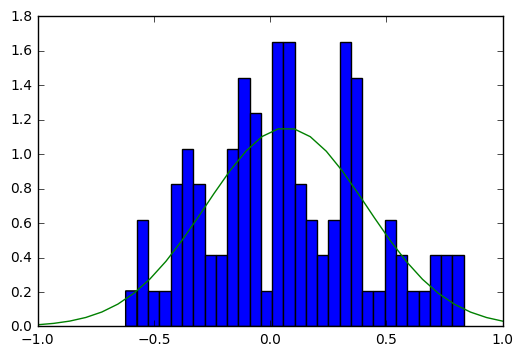

In [125]:
plt.hist(latePreds,30,normed=1)
plt.plot(x,latePdf)

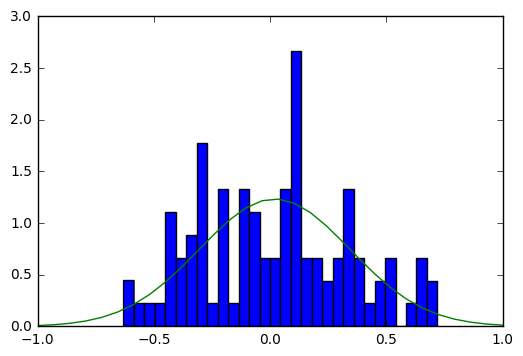

In [119]:
plt.hist(badPreds,30,normed=1)
plt.plot(x,badPdf)

In [120]:
KStest = st.ks_2samp(latePreds[:,0],badPreds[:,0])
KStest

Ks_2sampResult(statistic=0.10000000000000001, pvalue=0.67662014970024587)

In [ ]:
lateTrials= DataHandler(dataset, trainSize)
lateTrials.trialShuffle()
earlyTrials= DataHandler(dataset, trainSize)
earlyTrials.trialShuffle()

earlyTrainer = ClassifierHandler(30)
earlyClfBox = earlyTrainer.generateClassifiers(earlyTrials)

# Automate process

In [73]:
#endingDS = dataset[:40,:20,650:750]
#beginningDS = dataset[:40,:20,50:150]
#timesToUse = np.arange(20)
def late_early_bad(endingDS, beginningDS, timesToUse, trainSize, clf=SVC()):

    badData = DataHandler(endingDS, trainSize)
    badData.trialShuffle()
    badData.binShuffle()
    lateData = DataHandler(endingDS, trainSize)
    lateData.trialShuffle()
    earlyData = DataHandler(beginningDS, trainSize)
    earlyData.trialShuffle()
    
    trainer = ClassifierHandler(30,clf)
    predMaker = PredictionsHandler()
    
    clfLateBox = trainer.generateClassifiers(lateData)
    clfEarlyBox = trainer.generateClassifiers(earlyData)
    clfBadBox = trainer.generateClassifiers(badData)
    
    
    latePreds = predMaker.predictAllResults(lateData, clfLateBox)
    earlyPreds = predMaker.predictAllResults(earlyData, clfEarlyBox)
    badPreds = predMaker.predictAllResults(badData, clfBadBox)
    mixedPreds = predMaker.predictAllResults(earlyData, clfLateBox)

    lateCorrs = predMaker.correlate(latePreds, timesToUse)
    earlyCorrs = predMaker.correlate(earlyPreds, timesToUse)
    badCorrs = predMaker.correlate(badPreds, timesToUse)
    mixedCorrs = predMaker.correlate(mixedPreds, timesToUse)
    
    meanStdCorr={}
    t_tests = {}
    KStests = {}
    
    meanStdCorr['early'] = (earlyCorrs.mean(), earlyCorrs.std())
    meanStdCorr['late'] = (lateCorrs.mean(), lateCorrs.std())
    meanStdCorr['bad'] = (badCorrs.mean(), badCorrs.std())
    meanStdCorr['mixed'] = (mixedCorrs.mean(), mixedCorrs.std())
             
    t_tests['early_late'] = st.ttest_ind(lateCorrs,earlyCorrs,equal_var=False).pvalue[0]
    t_tests['early_bad'] = st.ttest_ind(earlyCorrs,badCorrs,equal_var=False).pvalue[0]
    t_tests['bad_late'] = st.ttest_ind(lateCorrs,badCorrs,equal_var=False).pvalue[0]
    t_tests['mixed'] = st.ttest_ind(earlyCorrs,mixedCorrs,equal_var=False).pvalue[0]
    
    KStests['early_late'] = st.ks_2samp(lateCorrs[:,0],earlyCorrs[:,0]).pvalue
    KStests['early_bad'] = st.ks_2samp(badCorrs[:,0],earlyCorrs[:,0]).pvalue
    KStests['bad_late'] = st.ks_2samp(lateCorrs[:,0],badCorrs[:,0]).pvalue
    KStests['mixed'] = st.ks_2samp(earlyCorrs[:,0],mixedCorrs[:,0]).pvalue
    
    return t_tests,KStests,meanStdCorr

## Lots of tests

In [16]:
timesToUse=np.arange(20)
trainSize=60

In [228]:
rato7smallBin = loadmat('R7.mat')['C']
rato7smallBin =  np.nan_to_num(np.swapaxes(rato7smallBin,0,2))
rato7smallBin.shape

(22, 39, 334)

In [230]:
endingDS = rato7smallBin[:22,:20,234:334]
beginningDS = rato7smallBin[:22,:20,0:100]
T_KS_MeanStd_small7 = late_early_bad(endingDS, beginningDS, timesToUse, trainSize)

pickle.dump(T_KS_MeanStd_small7, open('small7rat1804.pickle', 'wb'))

In [233]:
T_KS_MeanStd_small7

({'bad_late': 5.4114911064995028e-174,
  'early_bad': 0.0,
  'early_late': 3.4557268473125422e-52,
  'mixed': 2.4708635093901994e-184},
 {'bad_late': 6.337998725829504e-107,
  'early_bad': 5.2000320892490238e-288,
  'early_late': 9.1063525962478548e-47,
  'mixed': 5.9083245001847669e-119},
 {'bad': (-0.0083725005967331366, 0.23482017955685552),
  'early': (0.26397690167504528, 0.20806499893539709),
  'late': (0.17312802835418734, 0.24839494994977421),
  'mixed': (0.09845007864549854, 0.21910348710080743)})

In [17]:
rato7bigBin = loadmat('dados_R7_dt01.mat')['C']
rato7bigBin = np.nan_to_num(np.swapaxes(rato7bigBin,0,2))
rato7bigBin.shape

(22, 39, 507)

In [18]:
endingDS = rato7bigBin[:22,:10,407:507]
beginningDS = rato7bigBin[:22,:10,0:100]

big7_T_KS_MeanStd = late_early_bad(endingDS, beginningDS, np.arange(10), trainSize)

pickle.dump(big7_T_KS_MeanStd, open('big7rat1804.pickle', 'wb'))

/home/estevao/py2_kernel/local/lib/python2.7/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [21]:
big7_T_KS_MeanStd

({'bad_late': 4.8275195662665581e-31,
  'early_bad': 0.021716710247401322,
  'early_late': 3.501632020481739e-17,
  'mixed': 1.9131121942443156e-06},
 {'bad_late': 1.1287050473619016e-17,
  'early_bad': 0.0003458028255797442,
  'early_late': 1.9784657000527519e-15,
  'mixed': 4.4467505395101334e-10},
 {'bad': (-0.015041781837207226, 0.324170498916175),
  'early': (0.0059551772241131697, 0.35184632165574392),
  'late': (0.082906910578905785, 0.31611995823426903),
  'mixed': (-0.041044825396271314, 0.36937642649459551)})

In [19]:
rato10bigBin = loadmat('dados_R10_dt01.mat')['C']
rato10bigBin = np.nan_to_num(np.swapaxes(rato10bigBin,0,2))
rato10bigBin.shape

(69, 39, 707)

In [45]:
rato10bigBin[:40,:,:].sum()

0.0

In [51]:
rato10bigBin[40:,:,:].sum()

1883.2266655898256

In [52]:
endingDS = rato10bigBin[40:,:10,600:700]
beginningDS = rato10bigBin[40:,:10,50:150]

big10_T_KS_MeanStd = late_early_bad(endingDS, beginningDS, np.arange(10), trainSize)
pickle.dump(big10_T_KS_MeanStd, open('big10rat1804.pickle', 'wb'))

In [55]:
big10_T_KS_MeanStd

({'bad_late': 0.13516157606402843,
  'early_bad': 1.5510733309193908e-14,
  'early_late': 8.7976052976388646e-09,
  'mixed': 0.017441591719247813},
 {'bad_late': 4.32206019382936e-06,
  'early_bad': 1.6760477339058361e-29,
  'early_late': 5.252167321031178e-12,
  'mixed': 0.0010640902960726479},
 {'bad': (-0.017256596277138207, 0.32133993576842607),
  'early': (0.07805702086525633, 0.35977204180953753),
  'late': (-0.00042278449091180437, 0.35462699467932024),
  'mixed': (0.037286424088120877, 0.35745499444062329)})

In [53]:
rato10smallBin = loadmat('data_R10.mat')['C2']
rato10smallBin.shape

(77, 31, 753)

In [54]:
endingDS = rato10smallBin[:40,:20,650:750]
beginningDS = rato10smallBin[:40,:20,50:150]

small10_T_KS_MeanStd = late_early_bad(endingDS, beginningDS, timesToUse, trainSize)
pickle.dump(small10_T_KS_MeanStd, open('small10rat1804.pickle', 'wb'))

In [56]:
small10_T_KS_MeanStd

({'bad_late': 0.0,
  'early_bad': 0.0,
  'early_late': 1.1264795278562822e-11,
  'mixed': 1.0798020683522822e-59},
 {'bad_late': 2.7020452209914131e-291,
  'early_bad': 1.0097663377853873e-213,
  'early_late': 2.5879674358933836e-09,
  'mixed': 9.1487544274992275e-39},
 {'bad': (0.0098886056768404708, 0.22544656362460855),
  'early': (0.23823057186389734, 0.21476325530847432),
  'late': (0.27540539737842107, 0.20841358353410744),
  'mixed': (0.14558815632902242, 0.22063496454822873)})

## Testing linear classifier

In [80]:
endingDS = rato10smallBin[:40,:20,650:750]
beginningDS = rato10smallBin[:40,:20,50:150]

Linear_small10_T_KS_MeanStd = late_early_bad(endingDS, beginningDS, timesToUse, trainSize, LinearSVC())
pickle.dump(Linear_small10_T_KS_MeanStd, open('Linear_small10rat1804.pickle', 'wb'))

In [82]:
Linear_small10_T_KS_MeanStd

({'bad_late': 0.0,
  'early_bad': 4.4894147767172161e-302,
  'early_late': 7.1919839708971428e-53,
  'mixed': 1.9278126761626108e-16},
 {'bad_late': 0.0,
  'early_bad': 3.4067972484731228e-200,
  'early_late': 2.8859563160959073e-36,
  'mixed': 3.3319712408141567e-11},
 {'bad': (-0.0060811076457505447, 0.22623074376853791),
  'early': (0.21945370131636346, 0.21701700647904307),
  'late': (0.30403475106808331, 0.20668529385208712),
  'mixed': (0.17385501387705243, 0.21099177828701485)})